# Introduction aux SVM

## Implémentation des SVM

Les SVM reposent sur la résolution d'un problème d'optimisation quadratique convexe (formulation dual) de taille le nombre d'exemples. Indépendamment des algorithmes spécifiques aux SVM (SMO,...), il faut garder à l'esprit que la résolution d'un tel problème a une complexité au moins en $\mathcal{O}(n^2)$ où $n$ est le nombre d'exemples.

Néanmoins, dans le cas linéaire, il existe des implémentations de la descente de gradient stochastique, qui, si elles convergent moins bien, ont toutefois une complexité en $\mathcal{O}(n)$ et donc permettent de traiter des problèmes de grande taille.

La difficulté majeure des SVM est le réglage du paramètre de régularisation (souvent appelé $C$) dans tous les cas et dans le cas non linéaire le réglage du noyau (le noyau exponentiel le plus simple fait par exemple apparaître le paramètre $\gamma$).

Pour les règler, on procède comme pour les algorithmes de Machine Learning, on va tester des valeurs différentes de ces hyperparamètres. Pour chacune de ces valeurs, on va estimer l'erreur de généralisation (via la validation croisée). Il est malheureusement notoire que les SVM (notamment non linéaire) n'apprennent bien que par une gamme de valeurs d'hyperparamètres restreinte, aussi est-il important de chercher efficacement les meilleurs hyperparamètres.

Tout ceci nous conduit à la nécessité de disposer d'implémentations efficaces des SVM, il en existe quelques unes :
- `libsvm`, librairie en C++ wrappée en Python dans `sklearn` dans le module `svm`, qui traite les SVM non linéaires
- `liblinear`, librairie associée à la précédente qui traite les SVM linéaire et Regression Logistique et implémente des méthodes d'optimisation dédiées (pour les SVM mais aussi pour la Régression Logistique) wrappée en Python dans le module `LinearSVC` de `sklearn`
- `SGDClassifier` qui provient d'une implémentation d'une Stochastic Gradient Descent pour les SVM par L. Bottou `svmsgd`

## Introduction avec `scikit-learn`

Pour cette introduction aux SVM, on va utiliser un dataset classique en régression: `Pima Diabetes Dataset`

In [1]:
from sklearn import datasets
diab = datasets.load_diabetes()

`scikit-learn` dispose de quelques datasets classiques. Ce dernier vient d'une étude très connue sur l'apparition du diabète sur des femmes indiennes.

In [2]:
print(diab.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [3]:
X = diab.data
y = diab.target

On commence par séparer les données en base d'apprentissage et base de test.
*NB* : la base de test est à oublier pendant toute la construction du modèle, elle ne sera appelée à la toute fin, une fois le modèle final entraîné. Ces données correspondent à ce que notre modèle prédictif mis en production aurait comme entrées.

In [4]:
from sklearn.model_selection import train_test_split

Cette dernière fonction est très simple

In [5]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, **options)
    Split arrays or matrices into random train and test subsets
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float, int or None, optional (default=None)
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. If ``train_s

On choisit de garder $20 \%$ de points dans une base de test.

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [7]:
X_train.shape

(353, 10)

In [8]:
from sklearn.model_selection import GridSearchCV

`GridSearchCV` va nous permettre de procéder à une validation croisée directement sans avoir à la programmer (même si ça n'a rien de compliqué)

On commence par initier une instance de SVM pour la classification

In [9]:
from sklearn.svm import SVR

In [16]:
clf_svm = SVR(gamma='auto')

Il s'agit d'un objet régresseur SVM qui comprend déjà beaucoup d'attributs et de méthodes

In [17]:
clf_svm.kernel

'rbf'

In [18]:
clf_svm.C

1.0

In [19]:
clf_svm.gamma

'auto'

In [20]:
clf_svm.epsilon

0.1

On a donc un objet permettant de réaliser une classification en s'appuyant sur les RBF kernel SVM avec des paramètres de régularisation et de noyau (méthode de réglage automatique)

## Entraînement

Pour entraîner cet objet sur les données

In [21]:
clf_svm.fit(X_train, Y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

On peut déjà estimer le score sur la base d'apprentissage

In [22]:
clf_svm.score(X_train, Y_train)

-0.021821874255633533

In [23]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


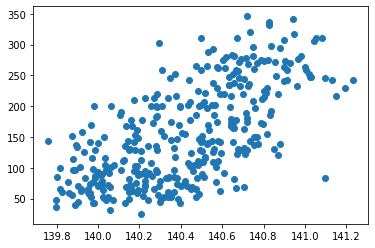

In [29]:
plt.plot(clf_svm.predict(X_train), Y_train,'o')

La régression n'est pas très efficace, elle donne quasiment la même valeur pour tous les échantillons. La meilleure solution est de parcourir l'espace des hyperparamètres et de réaliser pour chaque combinaison une estimation de l'erreur de généralisation par validation croisée.

In [30]:
gammas = np.logspace(0.5,1,5)
Cs     = np.logspace(1.7,2.5,5)
epsilons = np.logspace(0.2,0.7,5)

param_dict = [{'gamma': gammas, 'C': Cs, 'epsilon': epsilons}]
cv_svr = GridSearchCV(clf_svm, param_dict, cv = 5, refit=True)

In [31]:
cv_svr.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto', kernel='rbf', max_iter=-1,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': array([ 50.11872336,  79.43282347, 125.89254118, 199.5262315 ,
       316.22776602]),
                          'epsilon': array([1.58489319, 2.11348904, 2.81838293, 3.75837404, 5.01187234]),
                          'gamma': array([ 3.16227766,  4.21696503,  5.62341325,  7.49894209, 10.        ])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

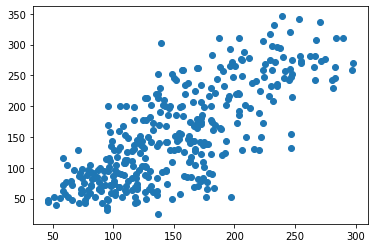

In [32]:
plt.plot(cv_svr.predict(X_train), Y_train,'o')

La régression s'est largement améliorée.

**Exercice 1** : Estimer l'erreur de généralisation à l'aide de la base de test.

**Exercice 2** : Tester avec d'autres noyaux

**Exercice 3** : Tester avec des SVR linéaires

## Reproduisons l'exemple du cours sur les SVM

In [33]:
from sklearn import svm, metrics, datasets

In [34]:
iris = datasets.load_iris()

Regardons la description des données

In [35]:
print ("Iris data set Description :: ", iris['DESCR'])

Iris data set Description ::  .. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== 

Il y a 4 variables d'entrée

In [36]:
X=iris.data

On stocke le numéro de la classe dans y, il varie entre 0 et 2

In [37]:
y=iris.target

Traçons les données

In [38]:
import matplotlib.pyplot as plt

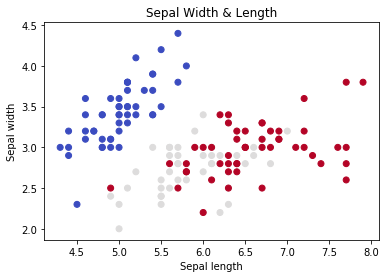

In [39]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('Sepal Width & Length')
plt.show()

Séparons les 150 données en 75 données d'apprentissage et 75 de test

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

Construisons une SVM pour la classification des données avec un coût pour une mauvaise classification C très elevé

In [42]:
svm_iris=svm.SVC(kernel='linear',C=1000000000)

In [43]:
svm_iris.fit(X_train,y_train)

SVC(C=1000000000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Faisons maintenant la prédiction sur la base de test

In [44]:
y_pred=svm_iris.predict(X_test)

Traçons la matrice de confusion

In [45]:
cm = metrics.confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n%s" % cm)

Confusion matrix:
[[22  0  0]
 [ 0 30  1]
 [ 0  3 19]]


**Exercice** : Tester avec d'autres noyaux et d'autres valeurs de C